# Data Science Homework 4
Try different imbalanced classification datasets using $k$-fold cross validation and various classification methods.
TODO List:
- Make sure we can open all the data as either DataFrame or nparray
- Handle categorical data (tokenize, one-hot encoding, ....)
- Split each dataset into training and testing dataset.
- Perform any necessary sampling, imputaiton, encoding techniques depending on dataset
- Perform 5-fold cross-validation to select datasets.

In [79]:
import os
import imblearn
import numpy as np
import pandas as pd
import xgboost
import lightgbm as lgb
import neuralnet # My simple nn
import sklearn.svm as svm
import sklearn.metrics as metrics
import category_encoders as ce # sklearn library
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split,  StratifiedKFold, cross_val_score

from sklearn import preprocessing

DATA_DIR = './data'
files = os.listdir(DATA_DIR)
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')

special_delims = { 'arcene_train.data': ' '}
no_headers = ['covtype.data', 'arcene_train.data']

numMethods = ['clip',
              'standard',
              'minmax',
              'bin',
              'rank'
            ]
ceMethods = ['onehot',
              'label',
              'feature',
              'target',
              'leaveoneout',
              'frequency'
             ]
modelNames = ['forest',
             'xgboost',
             'lightgbm',
             'mlp',
             'svm'
            ]

## Load datasets
Some datasets are in csv format, others have just the data. First convert to `DataFrame`s to allow for numeric, categorical values.

In [3]:

def load(name, header=True):
    sep = special_delims[name] if name in special_delims else ','
    name = os.path.join(DATA_DIR, name)
    if header:
        df = pd.read_csv(name, sep=sep)
    else:
        df = pd.read_csv(name, header=None, sep=sep)
    
    # Move target column to last
    if  'WineQT.csv' in name:
        cols = list(df.columns)
        x, y = cols.index('quality'), cols.index('Id')
        cols[x], cols[y] = cols[y], cols[x]
        df = df[cols]
    return df

## Encode Categorical Values

In [63]:
def encode_per_column(data, encoder):
    for column in data.columns:
        data.loc[:, column] = encoder.fit_transform(data.loc[:, column])
    return data
        
def encode_categorical(data:pd.DataFrame, method='ordinal', y=None):
    if method == 'ordinal':
        encoder = ce.OrdinalEncoder()
    elif method == 'onehot':
        encoder = ce.OneHotEncoder()
    elif method == 'label':
        encoder = preprocessing.LabelEncoder()
        #return encode_per_column(data,encoder)
    elif method == 'feature':
        encoder = FeatureHasher(n_features=10, input_type='string')
        encoder.transform(data.type)
    elif method == 'target':
        encoder = ce.target_encoder.TargetEncoder()
        
        return encoder.fit_transform(data.iloc[:, :-1], y)
    elif method == 'leaveoneout':
        y = data.iloc[:,-1]
        encoder = ce.LeaveOneOutEncoder()
        return encoder.fit_transform(data.iloc[:,:-1], y)
    elif method == 'frequency':
        encoder = ce.CountEncoder()
    return encoder.fit_transform(data)

def scale_features(data:pd.DataFrame, method='standard') -> pd.DataFrame:
    if method == 'standard':
        scaler = preprocessing.StandardScaler()
    elif method == 'minmax':
        scaler = preprocessing.MinMaxScaler()
    elif method == 'clip':
        for column in data.columns:
            p01 = data[column].quantile(.01)
            p99 = data[column].quantile(.99)
            data[column].clip(p01, p99)
        return data
    elif method == 'bin':
        for column in data.columns:
            data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
        return data
    elif method == 'rank':
        for column in data.columns:
            data.loc[:, column] = data[column].rank()
        return data
    
    return scaler.fit_transform(data)

## Train model:
The evalutation should be fixed on 5-fold cross validation, choose from `RandomForest`, `GBDT`, `XGBoost`,`LightBGM`, `CatBoost`, `KNN`, `Logistic Regression`,`MLP`, `SVM`.

Train a new model every iteration of the cross-validation.

In [64]:

def get_model(method):
    if method == 'xgboost':
        model = xgboost.XGBClassifier(5)
    elif method == 'knn':
        model = KNeighborsClassifier(n_neighbors=3)
    elif method == 'forest':
        model = RandomForestClassifier(10)
    elif method == 'lightgbm':
        model = lgb
    elif method == 'mlp':
        model = neuralnet.tabularNet()
    elif method == 'svm':
        model = svm.SVC()
    else:
        print(f'{method} not supported.')
        model = None
    return model

def get_metric(method):
    if method == 'acc':
        met = metrics.accuracy_score
    elif method == 'auc':
        met = metrics.auc
    elif method == 'roc_auc':
        met = metrics.roc_auc_score
    elif method == 'f1':
        met = metrics.f1_score
    elif method == 'prc':
        met = metrics.precision_recall_f1_support
    return met

def train(x, y, method='xgboost', metric='acc'):
    # Perform K-Fold cross validation
    metric = get_metric(metric)
    n_items = x.shape[0]
    kf = StratifiedKFold( n_splits=5, shuffle=True)
    model = get_model(method)
    mean_score = cross_val_score(model, x, y, cv=kf, n_jobs=1)
    '''
    mean_score = 0 
    for i, (train_index, test_index) in enumerate(kf.split(x, y)):
        model = get_model(method)
        x_train, x_test = x.iloc[train_index,: ], x.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # 
        try:
            if y_test.min().item()  != 0 and method == 'xgboost':
                y_train -= y_train.min().item() # Class labels should be zero-based
        except ValueError:
            pass
            
        model.fit(x_train, y_train)
        
        # Evaluate
        preds = model.predict(x_test)
        score = metric(y_test, preds)
        mean_score += score
        
    mean_score /= (i+1)
    #print(f'Mean score over validation: {mean_score} using {method}')
    '''
    return mean_score.mean(axis=0)
        

## P1: How does feature scaling (e.g. performing normalization) affect performance?
With standardization we apply the formula
$$x' = \frac{x - \mu}{\sigma}$$
so that we have 0 mean in the training data.

For One-hot Encoding we should not use this with tree-based models. For these models we can use label encoding, feature-hashing.
We should first encode the categorical values, then train the models on all our datasets both with feature scaling and without.

In [20]:
for file in files:
    
    df = load(file, False if file in no_headers else True)
    # Encode categorical columns
    cats = df.select_dtypes(include=['object'])
    df[cats.columns] = encode_categorical(cats)
    
    control = df.copy(deep=True) # Compare with standardized dataset

    df, labels = df.iloc[:, :-1], df.iloc[:, -1]
    control, c_labels = control.iloc[:, :-1], control.iloc[:, -1]
    
    # Feature scaling
    df = pd.DataFrame(scale_features(df))
    
    # Train model
    print(f'Training on {file}')
    score = train(df, labels, method='forest', metric='acc')
    print(f'train: {file}: avg: {score}')
   
    score = train(control, c_labels, method='forest', metric='acc')
    print(f'test: {file}: avg: {score}')
    print('\n')
    # The performance is mostly the same across models

Training on abalone.data


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


train: abalone.data: avg: 0.22624301635962524


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


test: abalone.data: avg: 0.22719107240065325


Training on bands.data
train: bands.data: avg: 0.7651715936119606


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


test: bands.data: avg: 0.7856269113149846


Training on biodeg.csv
train: biodeg.csv: avg: 0.8473933649289099
test: biodeg.csv: avg: 0.8530805687203792


Training on covtype.data


KeyboardInterrupt: 

## P2 When using tree-based algorithms, will usng one-hot encoding for categorical features generate worse performance than using label encoding? Why?
One-hot encoding transforms inputs with a range of $(1,\dots,n)$. This method generates extra columns and usually results in a sparse matrix.

Label Encoding adds replaces each unique class name with an integer.

In [61]:
for file in files:
    df = load(file, False if file in no_headers else True)
    target_column = df.columns[-1]
    label = df.copy(deep=True) # Use label encoding
    
    cats = label.select_dtypes(include=['object'])

    # Ignore files w/ no categorical data, otherw encoder error
    if cats.empty:
        print(f'No categorical in {file}\n')
        continue
        
    one_hot = pd.get_dummies(df, sparse=False)
    cats = label.select_dtypes(include=['object'])

    # Apply Label Encoder to each column

    label.loc[:, cats.columns] = encode_categorical(label.loc[:, cats.columns], method='label')
    
    # If target column is not categorical, labels will only be one column
    if df.dtypes[target_column] == object:
        n_unique = df[target_column].unique().shape[0] - 1
    else:
        n_unique = 1
    
    x_ohe, y_ohe = one_hot.iloc[:,:-n_unique], one_hot.iloc[:,-n_unique:]
    x_label, y_label = label.iloc[:,:-1], label.iloc[:,-1]
    
    #print(f'{file}: xcols: {len(x_label)} ycols: {len(y_label)}')
    #print(one_hot)
    print(f'Training on {file}')

    score = train(x_ohe, y_ohe, method='knn', metric='acc')
    print(f'\tOnehot avg: {score}')
    score = train(x_label, y_label, method='forest', metric='acc')
    print(f'\tlabel avg: {score}')
    print('\n')
    ## There is a slight difference in performance (label encoder usually better by a bit)

Training on abalone.data
	Onehot avg: 0.9971274675529325


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighb

	label avg: 0.23366558748531646


Training on bands.data


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

## P3
Will feature binning provide performance improvement? When is binning useful (which models or which kinds of datasets)?

Loop through each column in the dataframe and bin individually.
We use LabelEncoder for categorical features on both DataFrames.

In [65]:
for file in files:
    df = load(file, False if file in no_headers else True)
    binned = df.copy(deep=True)
    # TODO: fix arcene random space unable to parse
    if file == 'arcene_train.data':
        continue
    # Bin each column individually, use LabelEncoder for categorical
    for column in binned.columns:
        if (binned[column].dtype.name == 'int64'
           or binned[column].dtype.name == 'float64'):
            #n_unique = binned[column].unique() 
            binned[column]= pd.cut(binned[column], 5, labels=False, duplicates='drop')
            #binned[column].fillna(0, inplace=True)

            if binned[column].isnull().values.any():
                binned[colum] = 0
        #elif check if column is categorical
        elif binned[column].dtype.name == 'object':
            binned[column] = encode_categorical(binned[column], method='label')
            df[column] = encode_categorical(df[column], method='ordinal')

    # Train
    x_bin, y_bin = binned.iloc[:, :-1], binned.iloc[:, -1]
    x_label, y_label = df.iloc[:, :-1], df.iloc[:, -1]
    
    print(f'Training on {file}')
    score = train(x_bin, y_bin, method='forest', metric='acc')
    print(f'train: {file}: avg: {score}')
    
    score = train(x_label, y_label, method='forest', metric='acc')
    print(f'test: {file}: avg: {score}')
    print('\n')

Training on abalone.data
train: abalone.data: avg: 0.7570028364323983


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


test: abalone.data: avg: 0.22193364467237772


Training on bands.data


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


train: bands.data: avg: 0.7522935779816514
test: bands.data: avg: 0.7634726469588855


Training on biodeg.csv
train: biodeg.csv: avg: 0.8293838862559241
test: biodeg.csv: avg: 0.8625592417061612


Training on covtype.data
train: covtype.data: avg: 0.9399203455997348
test: covtype.data: avg: 0.9430166675103223


Training on dataset
train: dataset: avg: 0.8705780249410179
test: dataset: avg: 0.8752140208965284


Training on eeg_eye_state.arff
train: eeg_eye_state.arff: avg: 0.5511348464619491
test: eeg_eye_state.arff: avg: 0.8956608811749


Training on heart_2020_cleaned.csv
train: heart_2020_cleaned.csv: avg: 0.8967463531324755
test: heart_2020_cleaned.csv: avg: 0.8788849106458827


Training on HTRU_2.csv
train: HTRU_2.csv: avg: 0.9703859571897521
test: HTRU_2.csv: avg: 0.9787675312694628


Training on income_evaluation.csv
train: income_evaluation.csv: avg: 0.8259574406280994
test: income_evaluation.csv: avg: 0.8495132113395588


Training on phpAmSP4g.arff
train: phpAmSP4g.arff: avg: 0

## P4
Compare the performance of 6 different categorical feature encoding methods based on Random Forest, XGBoost LightGBM, MLP, SVM. Which of the 6 encoding methods is better?
TODO: Finish implementing neural network (missing dataloader)

Models to test: 
1. One hot encoding
2. Label Encoding
3. Feature Hasing
4. Frequency Encoding
5. Target Encoding
6. Leave One Out Encoding

In [81]:
for file in files:
    print(f'Checking {file}')
    df = load(file, header = False if file in no_headers else True)
    cats = df.select_dtypes(include=['object'])
    for method in ceMethods:
        # Encode features
        encoded = df.copy()
        
    
        encoded = encode_categorical(encoded, method=method)
     
            
        for modelName in modelNames:
            # Number of class columns, necessary for OHE
            #labelIndex = len(df.iloc[:,-1].unique()) if method == 'onehot' else 1
            labelIndex = 1
            enc_train, enc_test = encoded.iloc[:,:-labelIndex], encoded.iloc[:,-labelIndex:]
            score = train(enc_train, enc_test, modelName)
            print(f'\t({method}, {modelName}): {score}')
            

Checking abalone.data


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation

	(onehot, forest): 0.23222273157035214
	(onehot, xgboost): nan


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\mode

TypeError: estimator should be an estimator implementing 'fit' method, <module 'lightgbm' from 'C:\\Users\\Andres Ponce\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\lightgbm\\__init__.py'> was passed

## P5
Which combinations of numerical and categorical feature transformation methods generally lead to better results?

Here we can test the different numerical and categorical methods on each dataset.

In [54]:

for file in files:
    df = load(file, False if file in no_headers else True)
    print(f'Checking: {file}')
    # Encode only numerical columns
    for numMethod in numMethods:
        numcats = df.select_dtypes(include=['float64', 'int64'])
        scale_features(df[numcats.columns], method=numMethod)
        
        # Encode only categorical columns
        for ceMethod in ceMethods:
            cats = df.select_dtypes(include=['object'])
            encode_categorical(df[cats.columns], method=ceMethod)
            x, y = df.iloc[:, :-1], df.iloc[:, -1]
            score = train(x, y, method='forest')
            print(f'\tNumerical: {numMethod}, Categorical: {ceMethod}, Acc: {score}')
            

Checking: covtype.data
clip
	clip, label, 0.9424676226708968
standard


KeyboardInterrupt: 

## P6
If the number of possible categorical values of a feature is high, which encoding method among target encoding, one-hot encoding, and label encoding will have better performance? Why?

Go through each file, test each encoding method, and measure the $n$ datasets with most unique values.

In [32]:
enc_methods = [#'target',
               'onehot',
               'label',
              ]

for file in files:
    df = load(file, header=False if file in no_headers else True)
    print(f'Training on {file}')
    for enc_method in enc_methods:
        df_copy = df.copy()

        # OHE produces this many label columns
        n_labels = df_copy.iloc[:, -1].nunique() if enc_method == 'onehot' else 1
        
        # Encode df using method
        cats = df_copy.select_dtypes(include=['object'])
        if cats.empty:
            print(f'{file} has not categorical')
            continue
            
        max_uniques = max([len(df_copy[col].unique()) for col in cats.columns])
        if enc_method == 'onehot':
            print(n_labels)
            df_copy = pd.get_dummies(df_copy)
        else:
            df_copy[cats.columns] = encode_categorical(df_copy[cats.columns], method=enc_method, y=df_copy.iloc[:,-1])
            
        x, y = df_copy.iloc[:,:-n_labels], df_copy.iloc[:, -n_labels:]

        # Train model
        score = train(x, y, method='forest')
        print(f'\tmethod: {enc_method},  max unique categories: {max_uniques} score: {score}')
        


Training on abalone.data
28


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous-multioutput' instead.

## Plot class imbalance

abalone.data
bands.data
biodeg.csv
covtype.data
dataset
eeg_eye_state.arff
heart_2020_cleaned.csv
HTRU_2.csv
income_evaluation.csv
phpAmSP4g.arff
Raisin_Dataset.arff
spambase.data
UCI_Credit_Card.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
WineQT.csv


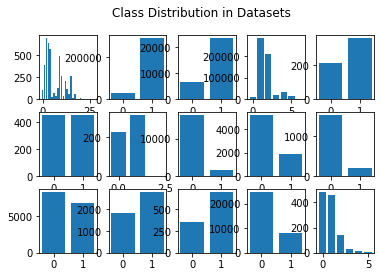

In [90]:
   
fig, axs = plt.subplots(3, 5)
fig.suptitle('Class Distribution in Datasets')
row, col = 0, 0
for i, file in enumerate(files):
    print(f'{file}')
    df = load(file, False if file in no_headers else True)
    row = row + 1 if i % 3 != 0 else 0
    col = col + 1 if i % 5 != 0 else 0
    
    target = df.iloc[:, -1]
    names, counts = [],[]
    for unique in target.unique():
        count = target[target == unique].count()
        counts.append(count)
        names.append(unique)
    #print(names, counts)
    axs[row, col].bar( range(len(counts)),counts)      
    #plot_imbalance(df, file)
plt.show()

## Imbalanced data samplers


In [150]:
def get_imb_sampler(method:str, y=None):
    if method == 'nearmiss':
        return imblearn.under_sampling.NearMiss(n_neighbors=get_least_frequent(y))
    elif method == 'clustercentroids':
        return imblearn.under_sampling.ClusterCentroids()
    elif method == 'condensednn':
        return imblearn.under_sampling.CondensedNearestNeighbour(n_neighbors=get_least_frequent(y))
    elif method == 'editednn':
        return imblearn.under_sampling.EditedNearestNeighbours(n_neighbors=get_least_frequent(y))
    elif method == 'neighbourhoodcleaning':
        return imblearn.under_sampling.NeighbourhoodCleaningRule(n_neighbors=get_least_frequent(y))
    elif method == 'tomeklinks':
        return imblearn.under_sampling.TomekLinks()
    elif method == 'onesidedselection':
        return imblearn.under_sampling.OneSidedSelection()
    elif method == 'smote':
        return imblearn.over_sampling.SMOTE()
    elif method == 'borderlinesmote':
        return imblearn.over_sampling.BorderlineSMOTE()
    elif method == 'adasyn':
        return imblearn.over_sampling.ADASYN(n_neighbors=get_least_frequent(y))
    elif method == 'svmsmote':
        return imblearn.over_sampling.SVMSMOTE(k_neighbors=get_least_frequent(y))

def get_least_frequent(y:pd.Series):
    return min(3, min(y.value_counts()))

def get_imb_sample(x:pd.DataFrame, y:pd.Series, s_method:str='nearmiss'):
    sampler = get_imb_sampler(us_method, y)
    # find least frequent class
    
    #sampler = sampler(n_neighbors=get_least_frequent(y))
    return sampler.fit_resample(x, y)

def train_imb(x:pd.DataFrame, y:pd.DataFrame, model='forest', eval_method='prc'): 
    # TODO: Use OVR classifier to 
    # Perform K-Fold cross validation'
   
    n_items = x.shape[0]
    kf = StratifiedKFold(n_splits=get_least_frequent(y), shuffle=True)
    mean_prec, mean_rec, mean_f, mean_supp = 0, 0, 0, 0
    for i, (train_index, test_index) in enumerate(kf.split(x, y)):
        model = get_model('forest')
        x_train, x_test = x.iloc[train_index,: ], x.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
            
        model.fit(x_train, y_train)
        
        # Evaluate
        preds = model.predict(x_test)
        prec,rec,f,supp =  metrics.precision_recall_fscore_support(y_test, preds, zero_division=0)
        mean_prec += prec
        mean_rec += rec
        mean_f += f
        mean_supp += supp
    return np.array([mean_prec, mean_rec, mean_f, mean_supp], dtype=np.float64).mean(axis=1) / (i)
    #print(f'Mean score over validation: {mean_score} using {method}')

        

## P7
Compare the classification performance of "doing nothing", 7 undersampling,4 oversampling, and 2 ensemble based methods in presence of class imbalance. Which method works generally best and the worst? Why?

Since we are interested in measuring our performance on the minority class, we use precision-recall curve.
First we get the training and testing data, and apply the sampling method on only the training set.

In [ ]:
under_sampling_methods = ['nearmiss',
                          'clustercentroids',
                          'condensednn',
                          'editednn',
                          'neighbourhoodcleaning',
                          'tomeklinks',
                          'onesidedselection'
                         ]

over_sampling_methods = ['smote',
                         'borderlinesmote',
                         'adasyn',
                         'svmsmote'
                        ]

for file in files:
    df = load(file, False if file in no_headers else True)
    # Encode df
    df = encode_categorical(df)
    # Split into testing and training set
    x, y = df.iloc[:, :-1], df.iloc[:, -1]
    print(f'Seeing: {file}: {get_least_frequent(y)}')

    if get_least_frequent(y) < 2:
        print('Cannot sample with less than two classes.')
        continue
    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
    
    # Undersample
    print('\tUndersampling')
    for us_method in under_sampling_methods:
        x_sample, y_sample  = get_imb_sample(x, y, s_method=us_method)
        scores = train_imb(x_sample, y_sample, model='forest')
        print(f'\t{us_method} mean precision: {scores[0]:.3f}, mean recall: {scores[1]:.3f} mean fscore: {scores[2]:.3f}, mean support: {scores[3]:.3f}')
    print('\n\tOversampling')
    for os_method in over_sampling_methods:
        # Do the same thing
        x_sample, y_sample = get_imb_sample(x, y, s_method=os_method)
        scores = train_imb(x_sample, y_sample, model='forest')
        print(f'\t{os_method} mean precision: {scores[0]:.3f}, mean recall: {scores[1]:.3f} mean fscore: {scores[2]:.3f}, mean support: {scores[3]:.3f}')


Seeing: abalone.data: 1
Cannot sample with less than two classes.
Seeing: bands.data: 2
	Undersampling
	nearmiss mean precision: 1.5, mean recall: 1.6666666666666667 mean fscore: 1.5555555555555554, mean support: 2.0
	clustercentroids mean precision: 0.8333333333333334, mean recall: 1.0 mean fscore: 0.8888888888888888, mean support: 2.0
	condensednn mean precision: 0.6666666666666666, mean recall: 0.8333333333333334 mean fscore: 0.7333333333333334, mean support: 2.6666666666666665
	editednn mean precision: 1.5095492300493234, mean recall: 1.4704732510288068 mean fscore: 1.4831928860902865, mean support: 84.33333333333333
	neighbourhoodcleaning mean precision: 1.3928515928515928, mean recall: 1.3847736625514404 mean fscore: 1.3814756088377542, mean support: 113.0
	tomeklinks mean precision: 1.353144075563468, mean recall: 1.3492560144625225 mean fscore: 1.350022929279177, mean support: 153.66666666666666
	onesidedselection mean precision: 1.2745098039215685, mean recall: 1.3333333333333

## P8
Can you find the datasets on which SMOTE-based oversampling works best? What does the data look like? Why?

We can use the results from the previous problem, and describe each of the dataframes to find some patterns.